# Pizza Sales! 🍕

Welcome to our Pizza Sales Challenge, here you’ll be playing the role of a Consultant hired by Plato's Pizza, a Greek-inspired pizza place in NYC, to help the restaurant use data to improve operations. You've received the following note:

> Welcome aboard, we're so glad you're here to help!
> Things are going OK here at Plato's, but there's room for improvement. We've been collecting transactional data for the past year, but really haven't been able to put it to good use. Hoping you can analyze the data and put together a report to help us find opportunities to drive more sales and work more efficiently.
>
> -Plato, CEO

Plato's Pizza has historically been using Excel for their sales reporting needs, but want to see if there could be a more effective, scalable solution. They want to be able to monitor key business metrics such as: 

* What days and times do we tend to be busiest?
* How many pizzas are we making during peak periods?
* What are our best and worst-selling pizzas?
* What's our average order value?

Let's use Atoti to analyze Plato's Pizza sales, and address their operational needs.

**💡 Note:** Our pizza dataset comes from [Kaggle](https://www.kaggle.com/datasets/shilongzhuang/pizza-sales/data), feel free to check it out!

## Import Libraries

First off, let's import the necessary libraries.

In [1]:
import atoti
import pandas as pd

## Instantiate Atoti Server and UI

Now, we'll spin up the Atoti server and link the session to our web-based Atoti UI.

**💡 Note:**  https://docs.atoti.io/latest/api/atoti.Session.html#atoti.Session

In [2]:
# Start an Atoti Server instance
session = atoti.Session(
    user_content_storage="./content",
    port=9092,
    java_options=["-Xms1G", "-Xmx10G"],
)
session.link

http://localhost:9092

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

## Inspect Data Quality Using Pandas

Next, let's load up Pandas to quickly take a look at the pizza sales data, inspect it's quality, and make quick formatting changes if need be.

In [3]:
# Read CSV into Pandas DataFrame
pizza_sales_df = pd.read_csv("s3://data.atoti.io/notebooks/pizza-sales/pizza_sales.csv")
pizza_sales_df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/15,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/15,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/15,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/15,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/15,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


Nice, looks like we're working with some pretty intact data.

In [4]:
# Check null counts for each column
pizza_sales_df.isnull().sum(axis=0)

order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

Let's take a look at the data types of our columns to see the intended hierarchies vs. measures (non-numerical vs. numerical columns) that Atoti will use when loaded.

In [5]:
# Check column data types
pizza_sales_df.dtypes

order_details_id       int64
order_id               int64
pizza_id              object
quantity               int64
order_date            object
order_time            object
unit_price           float64
total_price          float64
pizza_size            object
pizza_category        object
pizza_ingredients     object
pizza_name            object
dtype: object

## Format Data in Pandas

Upon inspection, it looks like a few things need to be updated:

* Our `order_date` column needs to be set to a DateTime data type.
* We need to create a `dayofweek` column/attribute to answer best/worst sales on week days.
* Intended hierarchies set as numerical data types should be set as strings for Atoti (e.g. no need to aggregate order ids!)

**💡 Note:**  https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Multidimensional-concepts

In [6]:
# Convert string to datetime and set day of the week (e.g. Monday=0, Sunday=6)
pizza_sales_df["order_datetime"] = pd.to_datetime(
    pizza_sales_df["order_date"] + " " + pizza_sales_df["order_time"], format="mixed"
)
pizza_sales_df["dayofweek"] = pizza_sales_df["order_datetime"].dt.day_name()

# Cast as string data types and view modified DataFrame
pizza_sales_df["order_details_id"] = pizza_sales_df["order_details_id"].astype(str)
pizza_sales_df["order_id"] = pizza_sales_df["order_id"].astype(str)
pizza_sales_df["dayofweek"] = pizza_sales_df["dayofweek"].astype(str)
pizza_sales_df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,order_datetime,dayofweek
0,1,1,hawaiian_m,1,1/1/15,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,2015-01-01 11:38:36,Thursday
1,2,2,classic_dlx_m,1,1/1/15,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015-01-01 11:57:40,Thursday
2,3,2,five_cheese_l,1,1/1/15,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,2015-01-01 11:57:40,Thursday
3,4,2,ital_supr_l,1,1/1/15,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,2015-01-01 11:57:40,Thursday
4,5,2,mexicana_m,1,1/1/15,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,2015-01-01 11:57:40,Thursday


Lastly, let's take a look at our column data types again to verify our data formatting. Great, looks like our changes went through!

In [7]:
# Check new column data types
pizza_sales_df.dtypes

order_details_id             object
order_id                     object
pizza_id                     object
quantity                      int64
order_date                   object
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
order_datetime       datetime64[ns]
dayofweek                    object
dtype: object

## Load Pandas DataFrame Into Atoti Cube

Now, let's load our formatted data from our Pandas DataFrame to an Atoti table using the `read_pandas()` function, verify that the data was loaded properly, and create our Atoti cube.

**💡 Note:**  https://docs.atoti.io/latest/api/atoti.Session.read_pandas.html#atoti.Session.read_pandas

In [8]:
# Load Pandas DataFrame as Atoti Table object
pizza_sales_table = session.read_pandas(
    pizza_sales_df, table_name="pizza_sales_table", keys=["order_details_id"]
)
pizza_sales_table.head()

,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,order_datetime,dayofweek
order_details_id,,,,,,,,,,,,,
13,7,spinach_supr_s,1,1/1/15,12:50:37,12.5,12.5,S,Supreme,"Spinach, Red Onions, Pepperoni, Tomatoes, Arti...",The Spinach Supreme Pizza,2015-01-01 12:50:37,Thursday
27,11,cali_ckn_l,1,1/1/15,13:02:59,20.75,20.75,L,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",The California Chicken Pizza,2015-01-01 13:02:59,Thursday
41,16,napolitana_s,1,1/1/15,13:34:07,12.0,12.0,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,2015-01-01 13:34:07,Thursday
55,19,sicilian_l,1,1/1/15,13:59:09,20.25,20.25,L,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza,2015-01-01 13:59:09,Thursday
69,26,classic_dlx_s,1,1/1/15,14:54:26,12.0,12.0,S,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015-01-01 14:54:26,Thursday


**💡 Note:**  https://docs.atoti.io/latest/api/atoti.Session.create_cube.html#atoti.Session.create_cube

In [9]:
# Create Cube from Atoti Table object
cube = session.create_cube(pizza_sales_table)

## Cube Data Model Analysis

Now, let's verify the cube has been set up properly, and take a look at the schema of the cube, along with the hierarchies, levels, and measures automatically created.

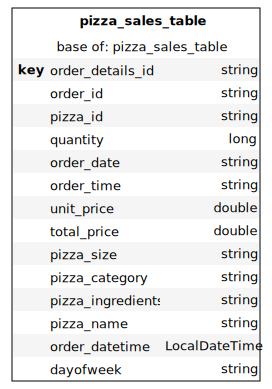

In [10]:
# View the schema
session.tables.schema

In [11]:
# Set variables for hierarchies, levels, and measures
h, l, m = cube.hierarchies, cube.levels, cube.measures

Remember that when slicing-and-dicing, we need to be specific on what we slice-and-dice on. In other words, hierarchies are the logical groupings of non-numeric attributes of our data model that we want to see aggregated numeric calculations for. For example, perhaps we want to see the total amount of revenue generated for each category in `pizza_category`. At this point in time for our pizza sales use case, our data model consists of "single-level hierarchies", where each hierarchy consists of a single level attribute.

In [12]:
h

{('pizza_sales_table', 'dayofweek'): <atoti.hierarchy.Hierarchy object at 0x2b55ac9a0>, ('pizza_sales_table', 'pizza_id'): <atoti.hierarchy.Hierarchy object at 0x2b55aca00>, ('pizza_sales_table', 'pizza_name'): <atoti.hierarchy.Hierarchy object at 0x2b55acaf0>, ('pizza_sales_table', 'order_datetime'): <atoti.hierarchy.Hierarchy object at 0x2b55acbe0>, ('pizza_sales_table', 'pizza_ingredients'): <atoti.hierarchy.Hierarchy object at 0x2b55accd0>, ('pizza_sales_table', 'order_id'): <atoti.hierarchy.Hierarchy object at 0x2b55acdc0>, ('pizza_sales_table', 'order_date'): <atoti.hierarchy.Hierarchy object at 0x2b55aceb0>, ('pizza_sales_table', 'order_details_id'): <atoti.hierarchy.Hierarchy object at 0x2b55acfa0>, ('pizza_sales_table', 'pizza_category'): <atoti.hierarchy.Hierarchy object at 0x2b55ad090>, ('pizza_sales_table', 'order_time'): <atoti.hierarchy.Hierarchy object at 0x2b55ad180>, ('pizza_sales_table', 'pizza_size'): <atoti.hierarchy.Hierarchy object at 0x2b55ad270>}

And so now we know that levels make up hierarchies, but suppose we have levels that are similar in nature to each other, in particular levels that have a parent-child relationship. For example, perhaps we have a city that belongs to a country so `Country` and `City` could be the two levels of a `Geography` hierarchy. Or more commonly (and in this particular example), we have an `order_datetime` hierarchy that could be split into multiple levels such as `Year`, `Month`, `Day`, `Hour`, etc. that would allow us to drill-down to the specific year, month, day, hour level when doing our calculations.

In [13]:
l

And lastly, measures are the numeric attributes that we want to aggregate depending on the hierarchies that we want to slice-and-dice on. So an example again could be the total amount of revenue (`total_price.SUM`) generated for every pizza category (`pizza_category`).

In [14]:
m

{'contributors.COUNT': <atoti.measure.Measure object at 0x2b21709d0>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x2b55d5f90>, 'unit_price.SUM': <atoti.measure.Measure object at 0x2b55d5f00>, 'unit_price.MEAN': <atoti.measure.Measure object at 0x2b55d5f30>, 'quantity.SUM': <atoti.measure.Measure object at 0x2b55d5d80>, 'quantity.MEAN': <atoti.measure.Measure object at 0x2b55d5e70>, 'total_price.SUM': <atoti.measure.Measure object at 0x2b55d5ea0>, 'total_price.MEAN': <atoti.measure.Measure object at 0x2b55d5e10>}

## Enriching the Cube

Now that we've gone over hierarchies, levels, and measures, lets add some additional hierarchies and configurations that will help us answer our analytical questions. In particular, we'll be adding a few multi-level hierarchies, and customizing the ordering for some of our levels.


In [15]:
# Create a multi-level date hierarchy
# For Year, Quarter, Month, Day, Hour
cube.create_date_hierarchy(
    "multi-level date",
    column=pizza_sales_table["order_datetime"],
    levels={
        "Year": "yyyy",
        "Quarter": "QQQ",
        "Month": "MMM",
        "Day": "dd",
        "Hour": "HH",
    },
)

# Create a multi-level date hierarchy
# For Weekday, and Hour
cube.create_date_hierarchy(
    "multi-level dayofweek",
    column=pizza_sales_table["order_datetime"],
    levels={
        "Weekday": "E",
        "Hour": "HH",
    },
)
h

{('pizza_sales_table', 'dayofweek'): <atoti.hierarchy.Hierarchy object at 0x2b55d7b80>, ('pizza_sales_table', 'pizza_id'): <atoti.hierarchy.Hierarchy object at 0x2b55d7970>, ('pizza_sales_table', 'pizza_name'): <atoti.hierarchy.Hierarchy object at 0x2b55d7640>, ('pizza_sales_table', 'order_datetime'): <atoti.hierarchy.Hierarchy object at 0x2b55d7700>, ('pizza_sales_table', 'multi-level date'): <atoti.hierarchy.Hierarchy object at 0x2b55d7670>, ('pizza_sales_table', 'multi-level dayofweek'): <atoti.hierarchy.Hierarchy object at 0x2b55d72e0>, ('pizza_sales_table', 'order_id'): <atoti.hierarchy.Hierarchy object at 0x2b55d6b90>, ('pizza_sales_table', 'order_details_id'): <atoti.hierarchy.Hierarchy object at 0x2b55d4100>, ('pizza_sales_table', 'order_time'): <atoti.hierarchy.Hierarchy object at 0x2b55d5270>, ('pizza_sales_table', 'pizza_ingredients'): <atoti.hierarchy.Hierarchy object at 0x2b55d5210>, ('pizza_sales_table', 'order_date'): <atoti.hierarchy.Hierarchy object at 0x2b55d4370>, ('pizza_sales_table', 'pizza_category'): <atoti.hierarchy.Hierarchy object at 0x2b55d5750>, ('pizza_sales_table', 'pizza_size'): <atoti.hierarchy.Hierarchy object at 0x2b55d5810>}

In [16]:
# Change `NaturalOrder` to `CustomOrder` for specific levels
l[("pizza_sales_table", "multi-level date", "Month")].order = atoti.CustomOrder(
    first_elements=[
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]
)
l[("pizza_sales_table", "multi-level dayofweek", "Weekday")].order = atoti.CustomOrder(
    first_elements=["Mon", "Tue", "Wed", "Thu", "Fri"]
)
l

## Data Analysis and Visualization in Atoti

With the data in the cube ready-to-go, let's now get to slicing-and-dicing! Be aware that from this point onwards we'll be using the Atoti JupyterLab extension which allows us to create notebook widgets and interact with Atoti and the data in the cube. Select the Atoti JupyterLab extension in your left-hand menu pane to follow along. Otherwise, you can always go to [http://localhost:9092/#/dashboard/e49](http://localhost:9092/#/dashboard/e49) to pull up the dashboard.

 

### What days and times do we tend to be busiest?

To answer this question, we need to analyze the amount of revenue generated per weekday, and when we determine which weekday generates the most revenue, we need to drill-down to the hourly revenue for that day to determine which day and time tends to be the busiest. Good thing we already made our `multi-level dayofweek` hierarchy! For the below, based on our analysis, it looks like Plato's Pizza generates the most revenue on Fridays.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
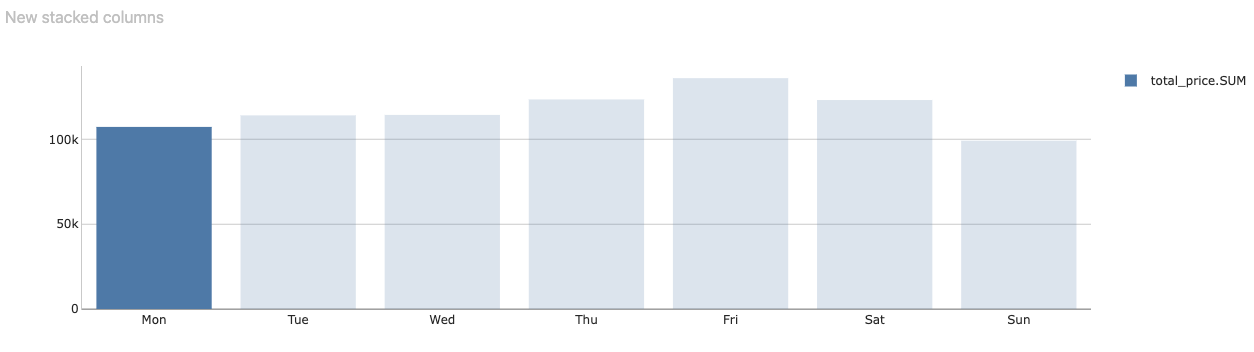

In [17]:
# X-axis: Weekday
# Y-axis: total_price.SUM
session.widget

Now, when we drill-down further and look at total revenue per hour, with a filter for Fridays only, we can see that around 12 PM is the time when Plato's Pizza tends to be busiest, which makes sense as that's typical of lunch rush hour! 🍕

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
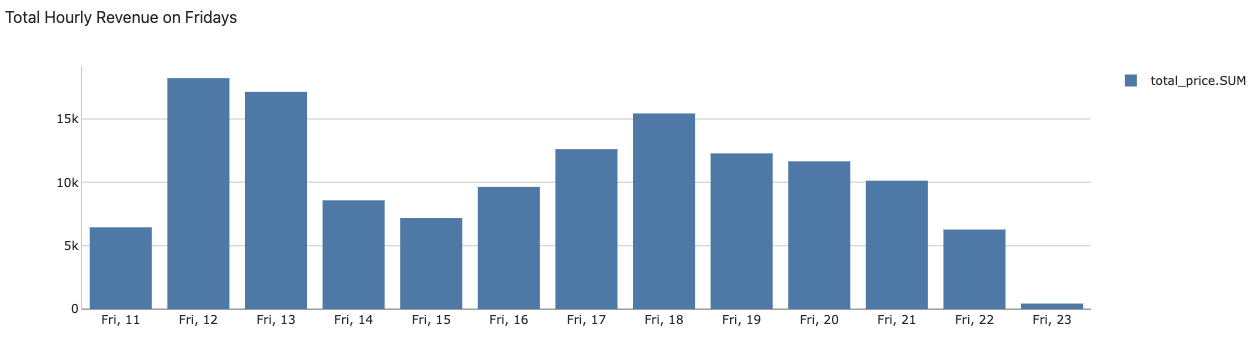

In [27]:
# X-axis: Hour
# Y-axis: total_price.SUM
# Filter: Fri
session.widget

### How many pizzas are we making during peak periods?

So we've determined that 12 PM on Fridays is our busiest time, but what about the amount of pizza sold? This is as easy as adding our `Quantity.SUM` measure to our visualization, and we've used a clustered Column graph to easily depict this. Looks like `1101` pizzas have been sold at Plato's Pizza's peak period.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
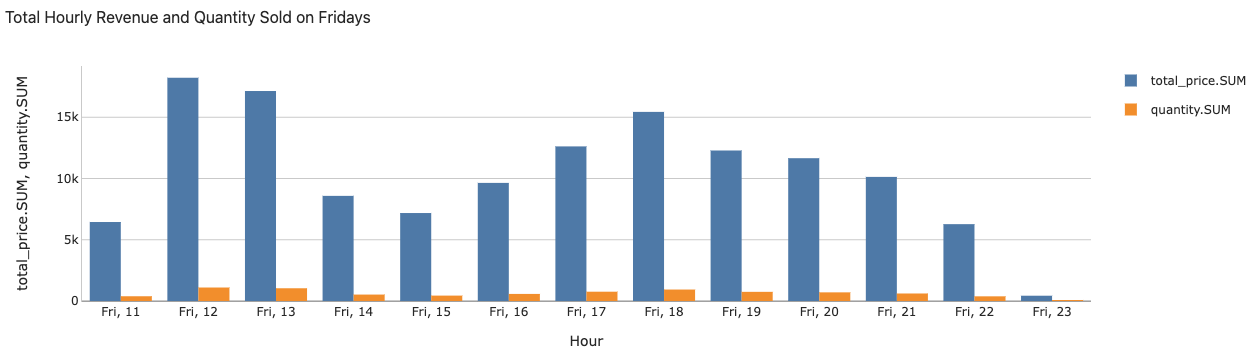

In [23]:
# X-axis: Hour
# Y-axis: total_price.SUM & quantity.SUM
# Filter: Fri
session.widget

### What are our best and worst-selling pizzas?

To anwser this question, we could simply create a visualization and sort by amount of revenue (`total_price.SUM`) generated for every pizza name (`pizza_name`), but perhaps Plato wants to see this as a percentage — how would we go about doing this? Answer: we can create new measures!

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
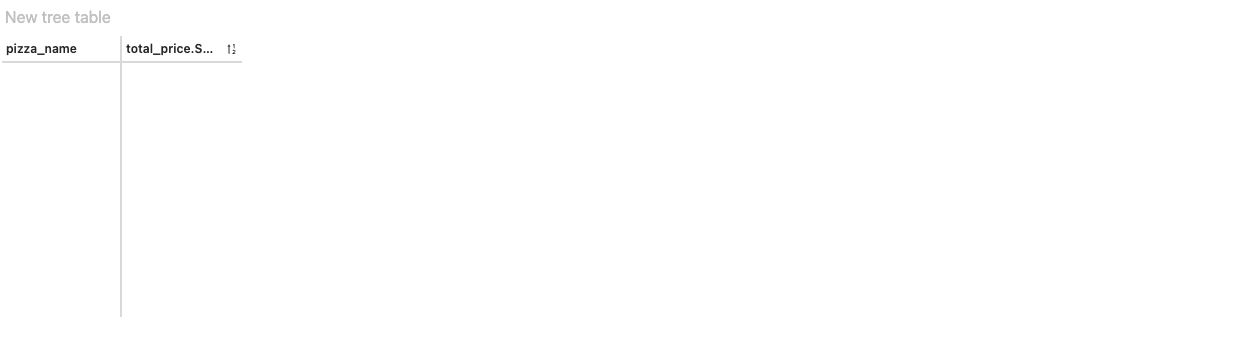

In [20]:
# X-axis: pizza_name
# Y-axis: total_price.SUM
session.widget

When creating new measures, we should be mindful of *how* we aggregate our numeric values and at which level. Therefore, we use the `atoti.total` function to sum up our `total_price.SUM` values at specific hierarchies. From the below, we can see that the `Thai Chicken Pizza` is the best selling pizza, while the `Brie Carre Pizza` is the worst selling pizza.

**💡 Note:** https://docs.atoti.io/latest/api/atoti.total.html#atoti.total

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
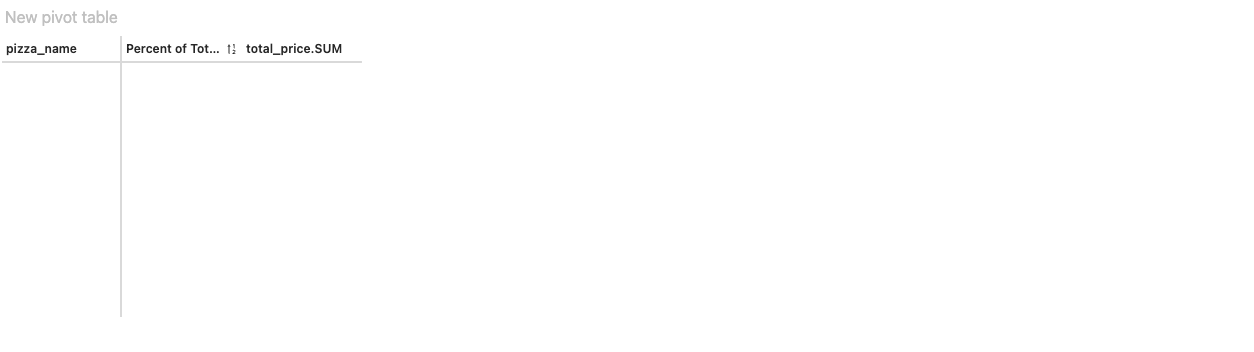

In [21]:
# Calculate percent of total revenue by pizza item (correct)
m["Percent of Total Revenue"] = m["total_price.SUM"] / atoti.total(
    m["total_price.SUM"], h["pizza_name"]
)
session.widget

### What's our average order value?

Lastly, let's calculate the average revenue per order. At first glance, this may be as simple as looking at `order_id` and the `total_price.MEAN` measure, but notice what this does. It calculates the average revenue down to the `pizza_id` level, which is not what we want! Instead, we want to see the average revenue per order at the `order_id` level. For this scenario, we need to calculate a new measure using the `atoti.agg.mean` function and specify the `scope` parameter using `OriginScope`. **To be clear, the `AVG Order Revenue` is the correct calculation, we've included the other columns just to show how `OriginScope` is functioning.**

**💡 Note:** https://docs.atoti.io/latest/api/atoti.OriginScope.html#atoti.OriginScope

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
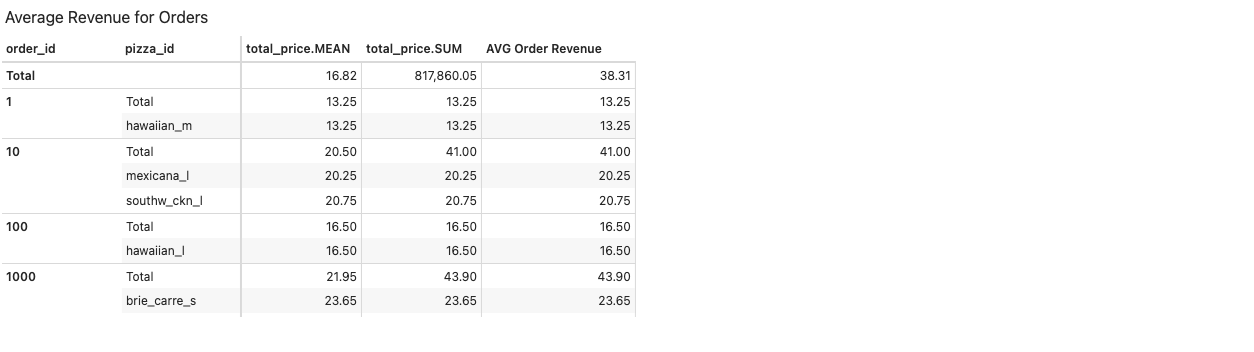

In [22]:
# Calculate average revenue per order
m["AVG Order Revenue"] = atoti.agg.mean(
    m["total_price.SUM"], scope=atoti.OriginScope(l["order_id"])
)
session.widget

## Summary

And that's it, here we were able to quickly analyze Plato Pizza's sales data and create visualizations, while customizing how we wanted these visualizations to look and how measures were calculated/aggregated. Can you think of some other ways to slice-and-dice this data to present as insightful findings? If so, feel free to extend this notebook and create a pull request to our GitHub repo!